In [1]:
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# TESTING DATASETS -
# DATASET A - Stationary, A_s samples, A_t steps, A_k arms.
# DATASET B - Non-Stationary - Big Switch in distributions, B_s samples, B_t steps, B_k arms.
# DATASET C - Non-Stationary - Small Movements in distributions, C_s samples, C_t steps, C_k arms.
# DATASET D - Stationary - Very high True Variance, C_s samples, C_t steps, C_k arms.

In [3]:
A_s, A_t, A_k = 1000, 500, 10
B_s, B_t, B_k = 1000, 1500, 4
C_s, C_t, C_k = 1000, 1500, 4
D_s, D_t, D_k = 1000, 1000, 10

In [4]:
np.random.seed(48)
from numpy.random import default_rng
rng = default_rng(48)   # deterministic, independent of global state

In [5]:
# DATASET A - Stationary, 1000 samples, 800 steps, 10 arms.

true_means_A = rng.normal(loc=0, scale=5, size=A_k)
true_variance_A = rng.uniform(low=0.8, high=1.5, size=A_k)

DATA_A = rng.normal(loc=true_means_A,scale=true_variance_A, size=(A_s, A_t, A_k))

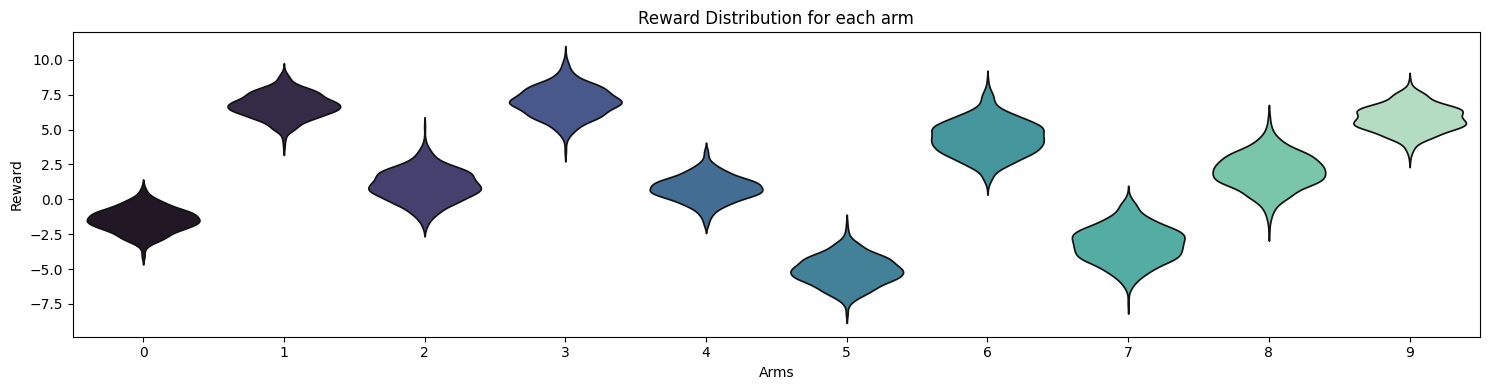

In [6]:
dist = DATA_A[11]
plt.figure(figsize=(15,4))
sns.violinplot(data=dist, inner=None, palette="mako")
plt.xlabel('Arms')
plt.ylabel('Reward')
plt.title('Reward Distribution for each arm')
plt.tight_layout()
plt.show()

In [13]:
# DATASET B - Non-Stationary - Big Switch in distributions at t=T/2

true_means_B = rng.normal(loc=0, scale=5, size=(2,B_k))
true_variance_B = rng.uniform(low=0.1, high=1, size=(2,B_k))

tmp = rng.normal(loc=true_means_B,scale=true_variance_B, size=(B_s,B_t//2,2,B_k))
DATA_B = tmp.transpose(0, 2, 1, 3).reshape(B_s, B_t, B_k)

In [14]:
dist = DATA_B[11]
n, n_features = dist.shape
x = np.tile(np.arange(0, B_k), B_t)
y = dist.flatten()
hue = np.concatenate((np.tile([1],B_k*B_t//2),np.tile([2],B_k*B_t//2)))

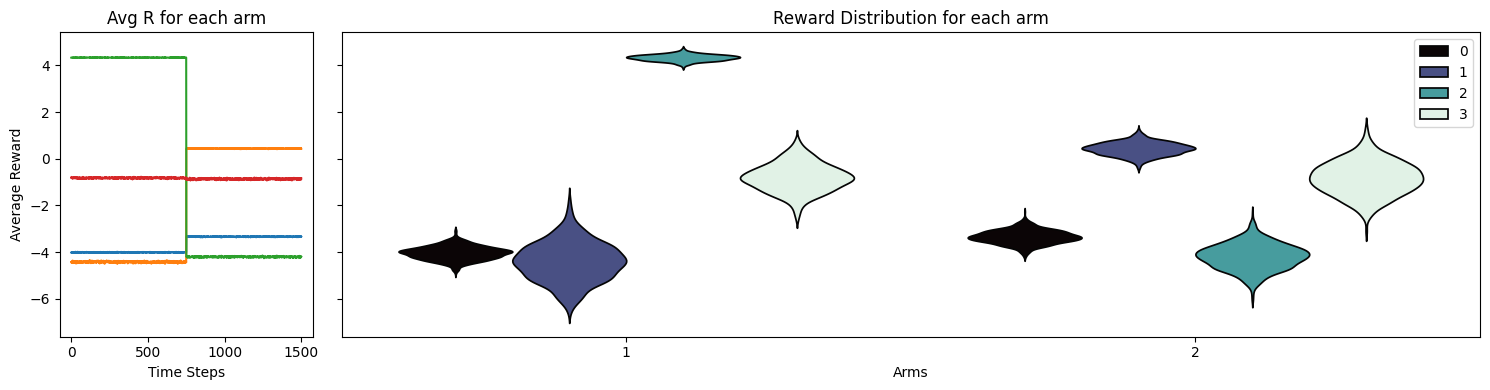

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True, gridspec_kw={'width_ratios': [2, 9]})
ax[0].plot(DATA_B.mean(axis=0))
ax[0].set_xlabel('Time Steps')
ax[0].set_ylabel('Average Reward')
ax[0].set_title('Avg R for each arm')

sns.violinplot(x=hue, y=y, hue=x, density_norm='width', inner=None, palette="mako", ax=ax[1])
ax[1].set_xlabel('Arms')
ax[1].set_title('Reward Distribution for each arm')
ax[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# DATASET C - Non-Stationary - Small Movements in distributions

mu = rng.normal(loc=0, scale=5, size=C_k)
shocks = rng.normal(loc=0, scale=0.25, size=(C_t,C_k))
true_means_C = np.cumsum(shocks, axis=0) + mu
true_variance_C = rng.uniform(low=0.1, high=1, size=C_k)

DATA_C = rng.normal(loc=true_means_C,scale=true_variance_C, size=(C_s,C_t,C_k))

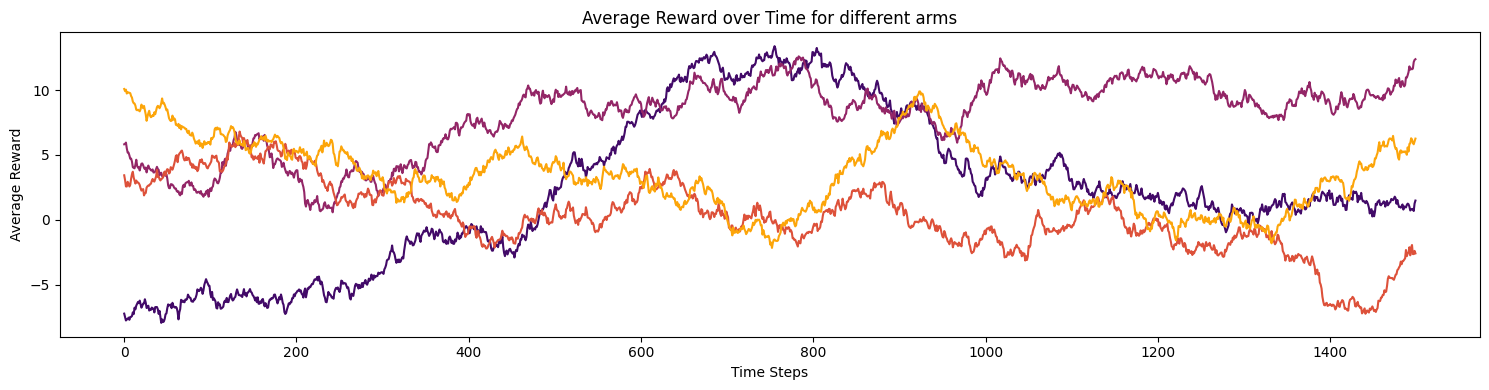

In [19]:
mus = DATA_C.mean(axis=0)
plt.figure(figsize=(15,4))
sns.lineplot(mus,legend=False, dashes=False, palette='inferno')
plt.xlabel('Time Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time for different arms')
plt.tight_layout()
plt.show()

In [20]:
# DATASET D - Stationary - Very high True Variance

true_means_D = rng.normal(loc=0, scale=10, size=D_k)
true_variance_D = 5

DATA_D = rng.normal(loc=true_means_D,scale=true_variance_D, size=(D_s,D_t,D_k))

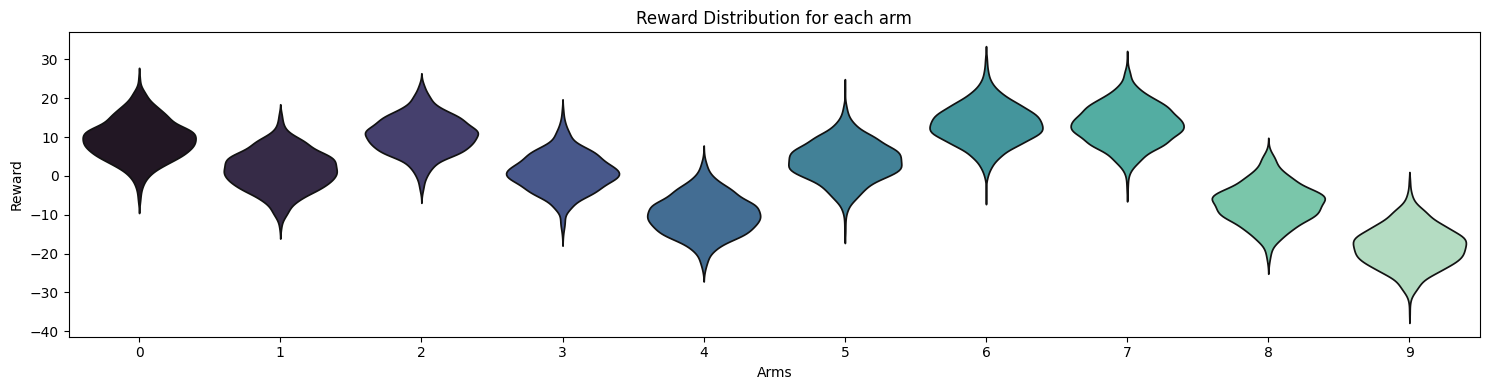

In [21]:
dist = DATA_D[52]
plt.figure(figsize=(15,4))
sns.violinplot(data=dist, inner=None, palette="mako")
plt.xlabel('Arms')
plt.ylabel('Reward')
plt.title('Reward Distribution for each arm')
plt.tight_layout()
plt.show()

In [22]:
def argmax(q_values):
    """Break ties randomly"""
    top = np.max(q_values)
    return np.random.choice(np.where(q_values == top)[0])

In [23]:
class main_agent():

    def __init__(self, param = None):
        if param is not None:
            print("Error, parameter values leaked: ",param)
        # Data vaiables - initialized with add data
        self.data = None
        self.samples = None
        self.steps = None
        self.arms = None
        self.scores = None
        # State variables - initialized in agent_reset
        self.q_values = None
        self.arm_count = None
        self.last_action = None
        self.last_reward = None

    def add_data(self, data):
        self.data = data
        self.samples, self.steps, self.arms = data.shape
        self.scores = np.zeros((self.samples, self.steps))
        return self

    def agent_step(self):
        """Select next action - to be overridden by subclasses"""
        return np.random.randint(self.arms)

    def agent_reset(self):
        """Reset agent state - to be overridden by subclasses if needed"""
        self.q_values = np.zeros(self.arms)
        self.arm_count = np.zeros(self.arms)

    def process_sample(self, s):
        """Process a single sample - returns the score array"""
        self.agent_reset()
        score_s = np.zeros(self.steps)
        sample = self.data[s]

        # Random first action
        self.last_action = np.random.randint(self.arms)
        score_s[0] = sample[0, self.last_action]
        self.last_reward = score_s[0]

        # Process remaining steps
        for i in range(1, self.steps):
            action = self.agent_step()
            reward = sample[i, action]
            score_s[i] = reward
            self.last_action = action
            self.last_reward = reward

        return score_s

    def process_data(self, n_jobs=1):
        """Process all samples with optional parallelization"""
        if n_jobs == 1:
            for s in range(self.samples):
                self.scores[s] = self.process_sample(s)
        else:
            def process_worker(s):
                agent = self.__class__.__new__(self.__class__)
                agent.__dict__.update(self.__dict__)
                agent.q_values = None
                agent.arm_count = None
                return agent.process_sample(s)

            self.scores = np.array(Parallel(n_jobs=self.n_jobs)(
                delayed(process_worker)(s) for s in range(self.samples)
            ))

        return self.scores

In [24]:
class greedy_agent(main_agent):
    """Greedy agent with incremental Q-value updates"""
    def agent_step(self):
        self.arm_count[self.last_action] += 1
        step = 1 / self.arm_count[self.last_action]
        self.q_values[self.last_action] += step * (self.last_reward - self.q_values[self.last_action])
        return argmax(self.q_values)

In [25]:
class optimistic_greedy_agent(greedy_agent):
    """Greedy agent with optimistic initial values"""
    def __init__(self, qst=20):
        super().__init__()
        self.qst = qst

    def agent_reset(self):
        self.q_values = np.ones(self.arms) * self.qst
        self.arm_count = np.zeros(self.arms)

In [26]:
class epsilon_greedy_agent(main_agent):
    """Epsilon-greedy agent with exploration"""
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon

    def agent_step(self):
        # Update Q-value
        self.arm_count[self.last_action] += 1
        step = 1 / self.arm_count[self.last_action] * (self.last_reward - self.q_values[self.last_action])
        self.q_values[self.last_action] += step

        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return np.random.randint(self.arms)
        else:
            return argmax(self.q_values)

In [27]:
class constant_step_epsilon_greedy_agent(epsilon_greedy_agent):
    """Epsilon-greedy with constant step size (for non-stationary problems)"""
    def __init__(self, args):
        epsilon = args[0]
        step_size = args[1]
        super().__init__(epsilon)
        self.step_size = step_size

    def agent_step(self):
        # Update with constant step size
        self.arm_count[self.last_action] += 1
        step = self.step_size * (self.last_reward - self.q_values[self.last_action])
        self.q_values[self.last_action] += step

        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return np.random.randint(self.arms)
        else:
            return argmax(self.q_values)

In [28]:
class unbiased_constant_step_epsilon_greedy_agent(epsilon_greedy_agent):
    """Epsilon-greedy with unbiased constant step size"""
    def __init__(self, args):
        epsilon = args[0]
        step_size = args[1]
        super().__init__(epsilon)
        self.step_size = step_size
        self.ofactor = None

    def agent_step(self):
        # Unbiased update
        self.arm_count[self.last_action] += 1
        o_ = self.ofactor[self.last_action]
        o = o_ + self.step_size * (1 - o_)
        self.ofactor[self.last_action] = o
        step = self.step_size * (self.last_reward - self.q_values[self.last_action]) / o
        self.q_values[self.last_action] += step

        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return np.random.randint(self.arms)
        else:
            return argmax(self.q_values)

    def agent_reset(self):
        self.q_values = np.zeros(self.arms)
        self.arm_count = np.zeros(self.arms)
        self.ofactor = np.zeros(self.arms)

In [29]:
class ucb_agent(main_agent):
    """Upper Confidence Bound agent"""
    def __init__(self, c=2):
        super().__init__()
        self.c = c

    def agent_step(self):
        # Update Q-value
        self.arm_count[self.last_action] += 1
        step = 1 / self.arm_count[self.last_action]
        self.q_values[self.last_action] += step * (self.last_reward - self.q_values[self.last_action])

        # UCB action selection
        T = np.sum(self.arm_count)
        ucb_values = self.q_values + self.c * np.sqrt(np.log(T) / (1e-3 + self.arm_count))
        return argmax(ucb_values)

In [30]:
class gradient_bandit_agent(main_agent):
    """Gradient bandit algorithm with baseline"""
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.baseline = None

    def agent_step(self):
        # Update baseline
        self.arm_count[self.last_action] += 1
        self.baseline += (self.last_reward - self.baseline) / np.sum(self.arm_count)

        # Compute softmax probabilities
        pi = np.exp(self.q_values - np.max(self.q_values))  # Numerical stability
        pi /= np.sum(pi)

        # Gradient update
        pi[self.last_action] -= 1
        self.q_values -= self.alpha * (self.last_reward - self.baseline) * pi

        # Sample action from updated policy
        pi = np.exp(self.q_values - np.max(self.q_values))
        pi /= np.sum(pi)
        return np.random.choice(self.arms, p=pi)

    def agent_reset(self):
        self.q_values = np.zeros(self.arms)
        self.arm_count = np.zeros(self.arms)
        self.baseline = 0

In [31]:
cache = {}

In [51]:
GLOBAL_MAPPING = {
    'DATA_A': DATA_A,
    'DATA_B': DATA_B,
    'DATA_C': DATA_C,
    'DATA_D': DATA_D,
    'main': main_agent,
    'greedy': greedy_agent,
    'optimistic_greedy': optimistic_greedy_agent,
    'epsilon_greedy': epsilon_greedy_agent,
    'constant_step_epsilon_greedy': constant_step_epsilon_greedy_agent,
    'unbiased_constant_step_epsilon_greedy': unbiased_constant_step_epsilon_greedy_agent,
    'ucb': ucb_agent,
    'gradient_bandit': gradient_bandit_agent
}

In [47]:
def run_one_config(config):
    """Run single agent configuration"""
    agent_name, data_id, params = config
    agent = GLOBAL_MAPPING[agent_name](params)
    agent = agent.add_data(GLOBAL_MAPPING[data_id])
    scores = agent.process_data()
    return scores.mean(axis=0)

In [34]:
def run_multiple_configs(configs,cache={},n_jobs_ot=4, n_jobs_in=1):
    """Run parameter study with caching and parallelization"""
    configs = set(configs)
    K = set(cache)
    to_compute = list(configs - K)
    computed = Parallel(n_jobs=n_jobs_ot)(
            delayed(run_one_config)(config) for config in to_compute
        )
    for config, result in zip(to_compute, computed):
        cache[config] = result
    return cache

In [56]:
def parameter_study(data_id, agents_params,cache={}, plot_1=True, plot_2=True, plot_3=True, n_jobs_ot=4, n_jobs_in=1):
    """Run parameter study with caching and parallelization"""
    configs = [(agent[0], data_id, param) for agent in agents_params for param in agent[1]]
    cache = run_multiple_configs(configs,cache,n_jobs_ot,n_jobs_in)

    if(plot_1):
        for agent in agents_params:
            agent_name = agent[0]
            params = agent[1]
            plt.figure(figsize=(10, 6))
            for param in params:
                score = cache[(agent_name,data_id,param)]
                mean = np.mean(score)
                sns.lineplot(score, label=f'{param}, score - {mean}', palette='mako')
            plt.legend()
            plt.title(agent_name)
            plt.xlabel('Steps')
            plt.ylabel('Average Reward on step')
            plt.grid(True, alpha=0.3)
            plt.show()

    if(plot_2):
        plt.figure(figsize=(12, 6))
        for agent in agents_params:
            agent_name = agent[0]
            params = agent[1]
            means = [np.mean(cache[(agent_name,data_id,param)]) for param in params]
            if(isinstance(params[0], tuple)):p = [i[0] for i in params]
            else: p = params
            sns.lineplot(x=p, y=means, label=agent_name, palette='mako')
        plt.legend()
        plt.title('Parameter Study Summary')
        plt.xlabel('Parameter Value')
        plt.ylabel('Mean Reward')
        plt.grid(True, alpha=0.3)
        plt.show()

    if(plot_3):
        plt.figure(figsize=(12, 6))
        for agent in agents_params:
            agent_name = agent[0]
            params = sorted(agent[1])
            means = [np.mean(cache[(agent_name,data_id,param)]) for param in params]
            sns.lineplot(means, label=agent_name, palette='mako')
        plt.legend()
        plt.title('Parameter Study Summary')
        plt.xlabel('Parameter Index')
        plt.ylabel('Mean Reward')
        plt.grid(True, alpha=0.3)
        plt.show()

In [102]:
def parameter_study(data_id, agents_params, cache={}, plot_1=True, plot_2=True, plot_3=True, n_jobs_ot=4, n_jobs_in=1):
    """Run parameter study with caching and parallelization."""
    configs = [(agent[0], data_id, param) for agent in agents_params for param in agent[1]]
    cache = run_multiple_configs(configs, cache, n_jobs_ot, n_jobs_in)

    # --- PLOT 1: per-agent, multiple subplots ---
    if plot_1:
        n = len(agents_params)
        fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), sharex=True)
        if n == 1:
            axes = [axes]
        for ax, (agent_name, params) in zip(axes, agents_params):
            for param in params:
                score = np.asarray(cache.get((agent_name, data_id, param)))
                if score is None:
                    continue
                mean = np.mean(score)
                ax.plot(score, lw=1.5, label=f"{param}, S={mean:.2f}")
            ax.set_title(agent_name)
            ax.set_xlabel('Steps')
            ax.set_ylabel('Reward')
            ax.grid(True, alpha=0.3)
            ax.legend()
        plt.suptitle('Parameter Study per Agent')
        plt.tight_layout()
        plt.show()
        print("="*128)

    # --- Helper for plots 2 and 3 ---
    def get_means(agent):
        agent_name, params = agent
        pvals = [p[0] if isinstance(p, tuple) else p for p in params]
        means = [np.mean(cache[(agent_name, data_id, param)]) for param in params if (agent_name, data_id, param) in cache]
        return agent_name, pvals, means

    # --- PLOT 2: parameter value vs mean reward ---
    if plot_2:
        plt.figure(figsize=(5, 4))
        for agent in agents_params:
            name, pvals, means = get_means(agent)
            plt.plot(pvals, means, label=name, marker='o', lw=1.5)
        plt.title('Parameter Value vs Mean Reward')
        plt.xlabel('Parameter Value')
        plt.ylabel('Mean Reward')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print("="*128)

    # --- PLOT 3: parameter index vs mean reward ---
    if plot_3:
        plt.figure(figsize=(5, 4))
        for agent in agents_params:
            name, pvals, means = get_means(agent)
            plt.plot(range(len(means)), means, label=name, marker='o', lw=1.5)
        plt.title('Parameter Index vs Mean Reward')
        plt.xlabel('Parameter Index')
        plt.ylabel('Mean Reward')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return cache

In [118]:
def different_datasets(data_ids, agents_params,cache={}, plot_1=True, n_jobs_ot=4, n_jobs_in=1):
    """Compare Agents across datasets with caching and parallelization"""
    configs = [(agent[0], data_id, param) for data_id in data_ids for agent in agents_params for param in agent[1]]
    cache = run_multiple_configs(configs,cache,n_jobs_ot,n_jobs_in)

    if(plot_1):
        n = len(data_ids)
        fig, axes = plt.subplots(n, 1, figsize=(10, 4*n))
        for idx in range(n):
            data_id = data_ids[idx]
            for agent in agents_params:
                agent_name = agent[0]
                params = agent[1]
                for p in params:
                    score = cache[(agent_name,data_id,p)]
                    mean = np.mean(score)
                    sns.lineplot(score, label=f'{agent_name} - {p}, score - {mean}', ax=axes[idx])
                    axes[idx].legend()
            axes[idx].set_title(data_id)
            axes[idx].set_xlabel('Steps')
            axes[idx].set_ylabel('Average Reward on step')
            axes[idx].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return cache

In [123]:
def cache_to_df(cache):
    """Convert cache dict to DataFrame summary."""
    rows = [
        {'Data': c[1], 'Model': c[0], 'Model Params': c[2],
         'Mean Score': np.mean(cache[c]), 'key': c}
        for c in cache
    ]
    return pd.DataFrame(rows).set_index('key')

In [67]:
cache = {}

In [100]:
sns.set_palette("Set1")

In [88]:
param_study = [
    ['epsilon_greedy',[1/64, 1/32, 1/16, 1/8, 1/4]],
    ['optimistic_greedy',[7, 8.5, 9.5, 10.5, 12]],
    ['constant_step_epsilon_greedy',[(0.25,0.0625), (0.625,0.0625), (0.90,0.0625), (1.2,0.0625)]],
    ['ucb',[0.04, 0.15, 0.6, 1.5, 3]],
    ['gradient_bandit',[0.05625, 0.1125, 0.225, 0.45, 0.9]]
]

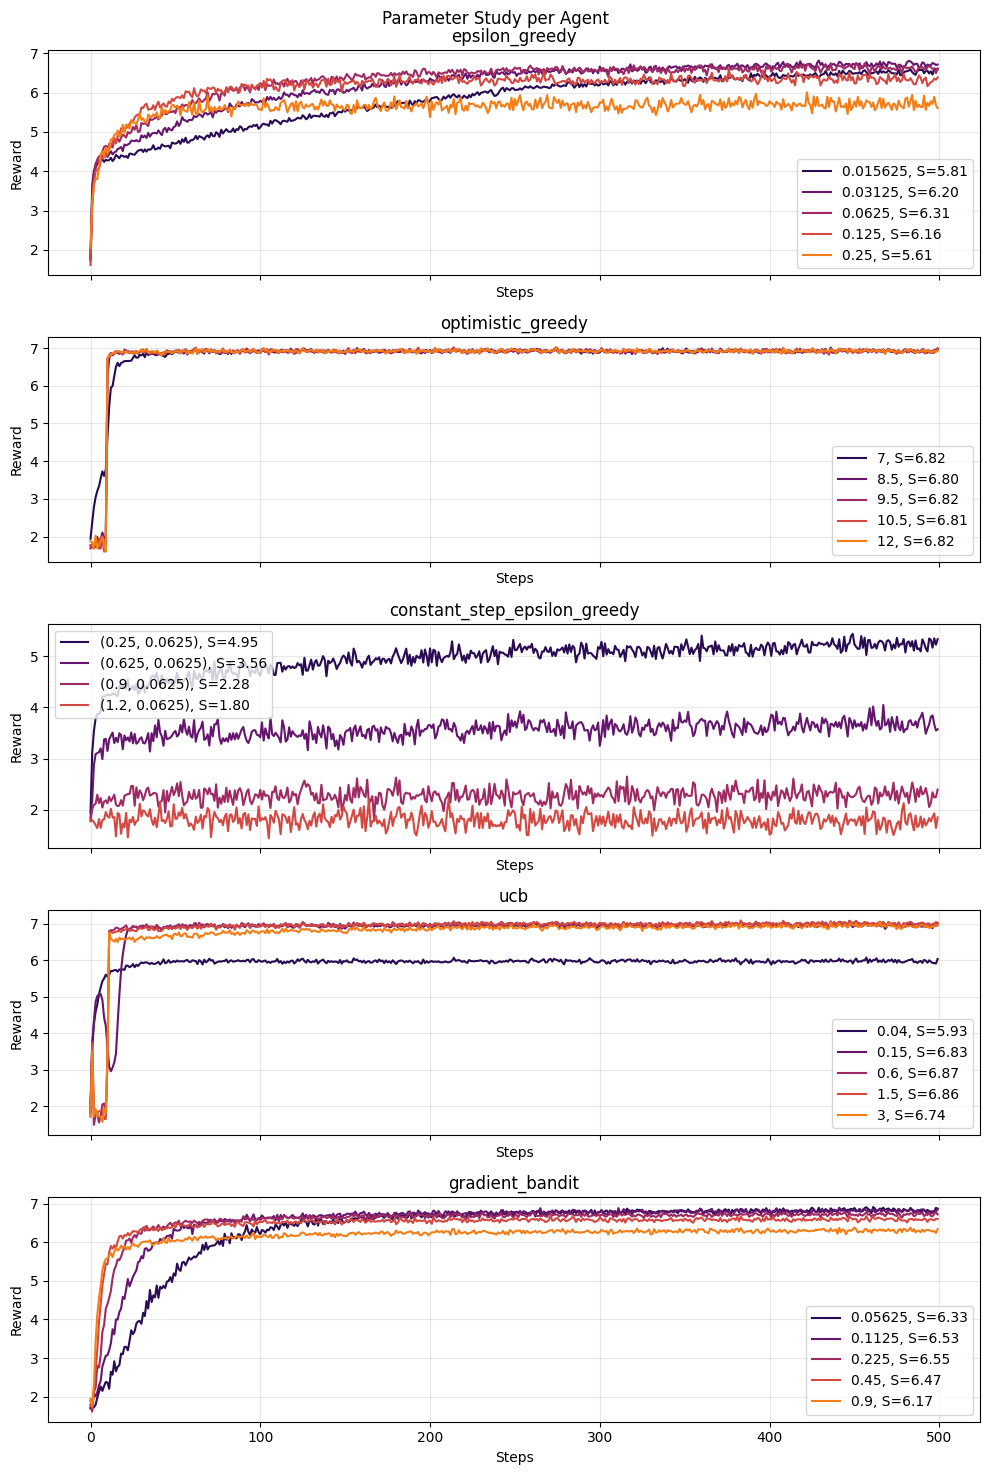

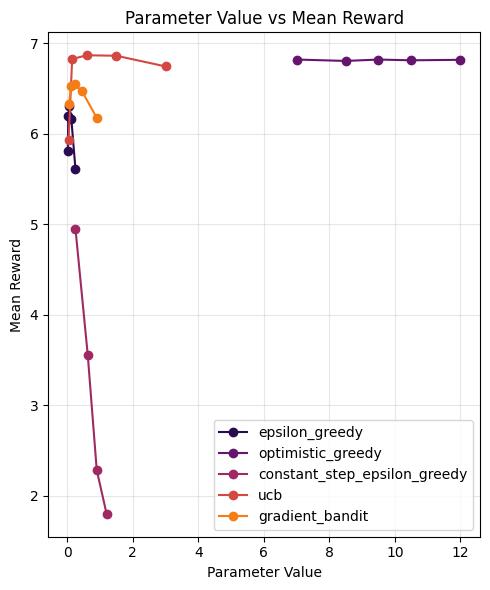

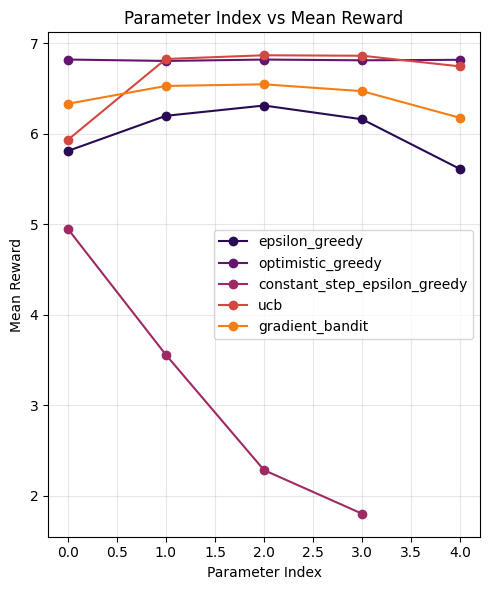

In [96]:
cache = parameter_study('DATA_A',param_study,cache)

In [103]:
true_means_A

array([-1.53812613,  6.74795633,  0.96413273,  7.03278981,  0.81103006,
       -5.09306361,  4.30224968, -3.19694689,  2.06847738,  5.8506584 ])

In [104]:
param_study_2 = [
    ['epsilon_greedy',[1/128,1/64, 1/32, 1/16, 1/8, 1/4]],
    ['optimistic_greedy',[0, 5, 6, 7, 8, 12]],
    ['constant_step_epsilon_greedy',[(0.01,0.0625),(0.05,0.0625),(0.1,0.0625), (0.25,0.0625), (0.625,0.0625)]],
    ['ucb',[0.04, 0.15, 0.6, 1.5, 6]],
    ['gradient_bandit',[0.01, 0.05625, 0.1125, 0.225, 0.45, 0.9, 1.2]]
]

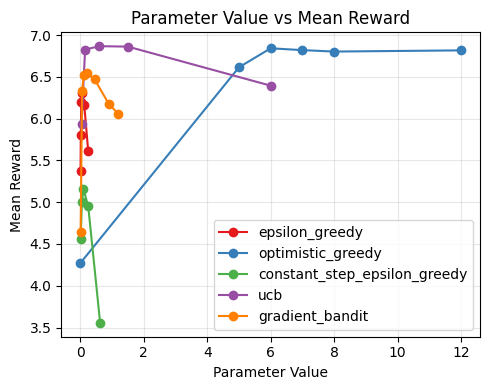

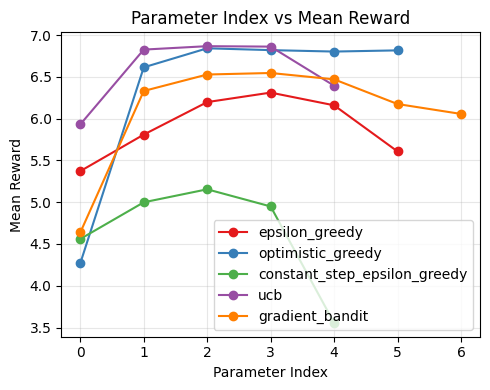

In [106]:
cache = parameter_study('DATA_A',param_study_2,cache, plot_1=False)

In [107]:
# OPTIMAL PARAMETERS for DATASET A
eps = 0.0625
qst = 6
step_size = 0.1
c = 1
alpha_H = 0.225

In [111]:
true_means_B.max(axis=1)

array([4.32869879, 0.43569884])

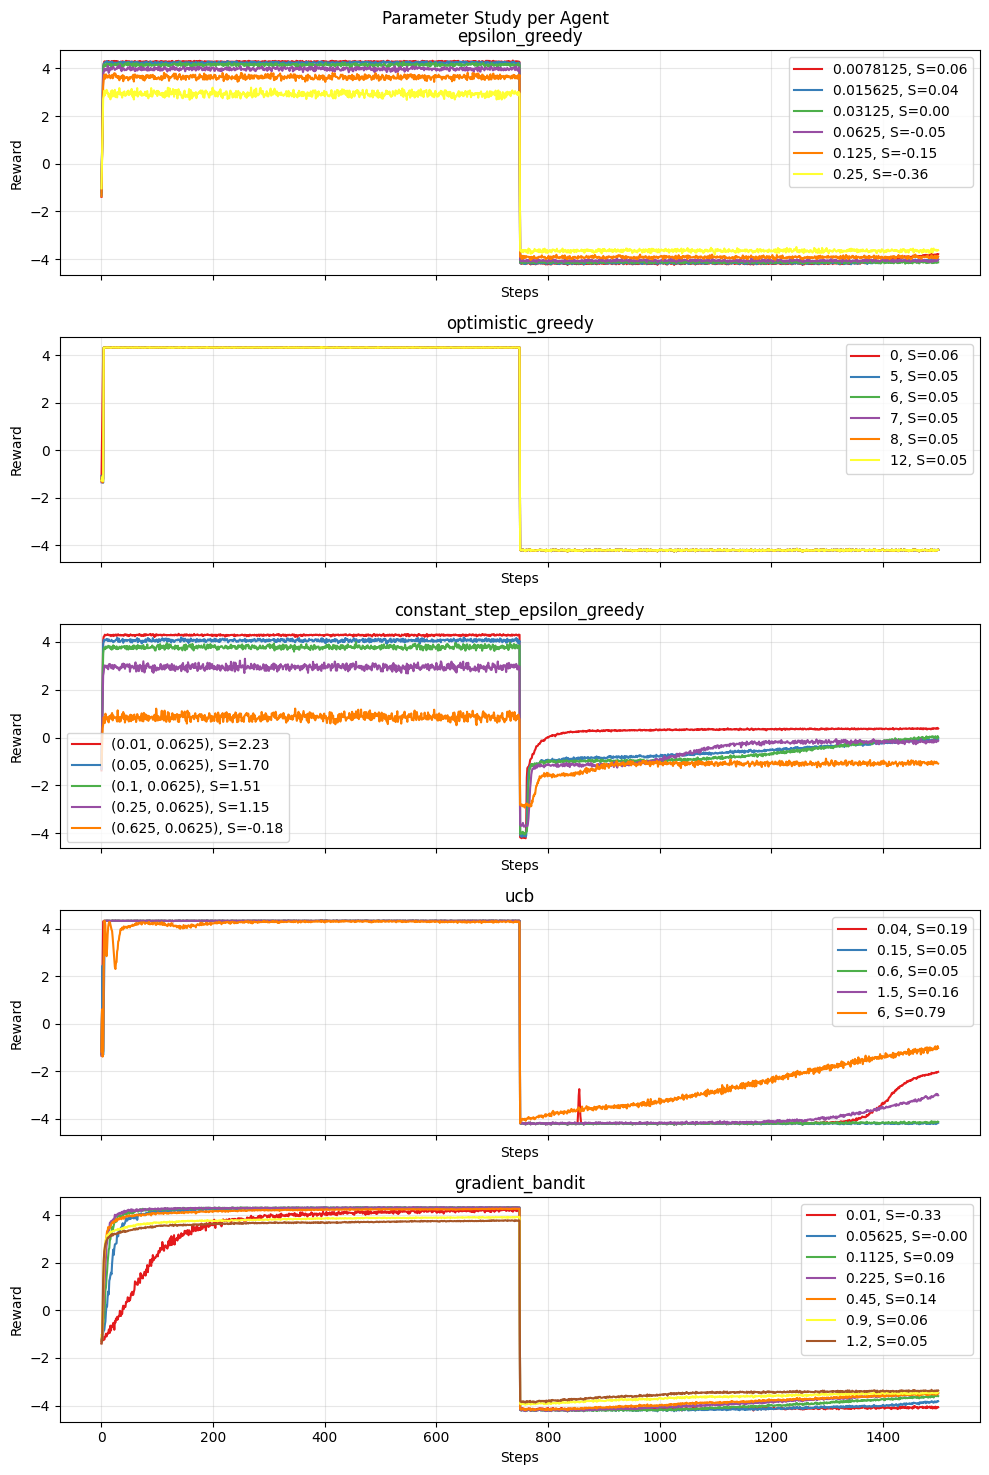

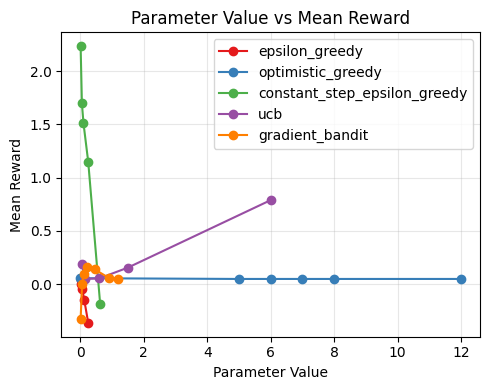

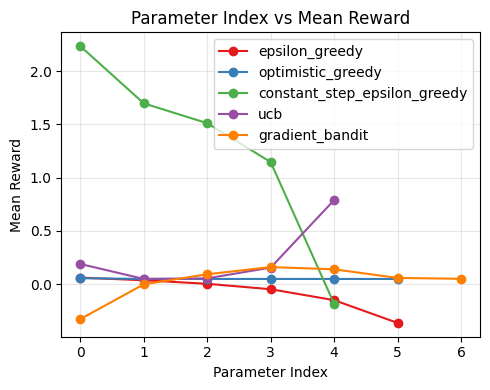

In [108]:
cache = parameter_study('DATA_B',param_study_2,cache)

In [112]:
agent_study = [
    ['epsilon_greedy',[1/16]],
    ['optimistic_greedy',[0, 10]],
    ['constant_step_epsilon_greedy',[(0.1,0.0625),(0.1,0.125)]],
    ['ucb',[1.5, 6]],
    ['gradient_bandit',[0.225]]
]

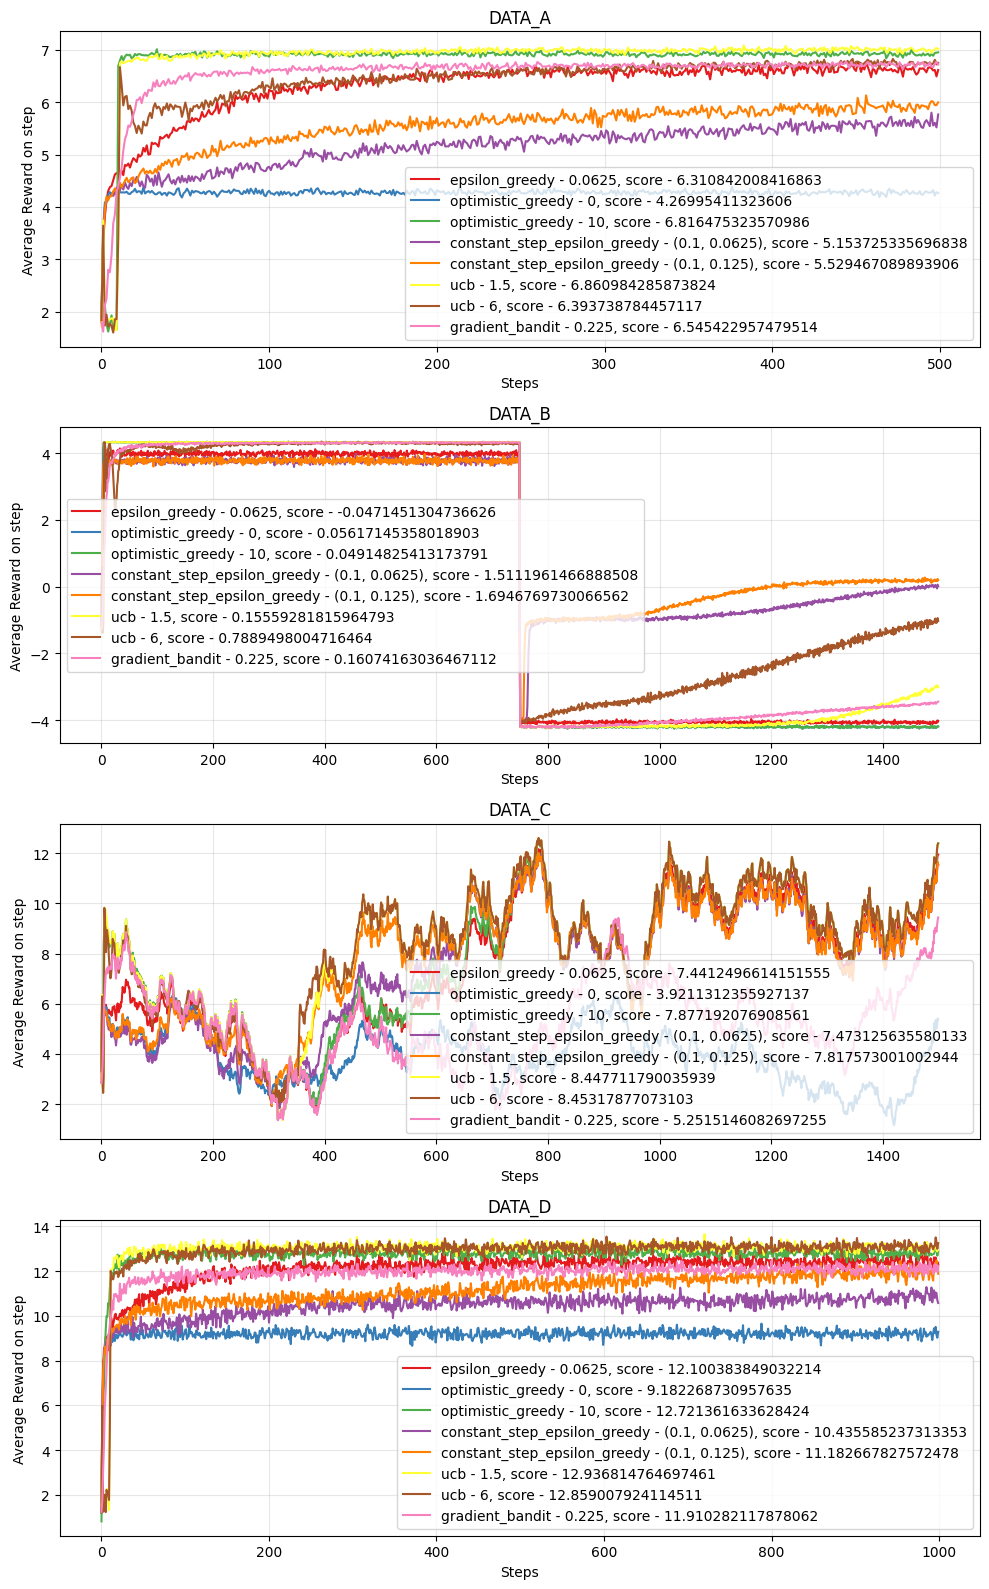

In [119]:
cache2 = different_datasets(data_ids=['DATA_A','DATA_B','DATA_C','DATA_D'],agents_params=agent_study,cache=cache2)

In [125]:
cache_df = cache_to_df(cache2)

In [126]:
cache_df[cache_df['Model']=='epsilon_greedy']

,Data,Model,Model Params,Mean Score
key,,,,
"(epsilon_greedy, DATA_A, 0.25)",DATA_A,epsilon_greedy,0.25,5.607042
"(epsilon_greedy, DATA_A, 0.01)",DATA_A,epsilon_greedy,0.01,5.476912
"(epsilon_greedy, DATA_A, 0.015625)",DATA_A,epsilon_greedy,0.015625,5.808229
"(epsilon_greedy, DATA_A, 0.03125)",DATA_A,epsilon_greedy,0.03125,6.197259
"(epsilon_greedy, DATA_A, 0.0625)",DATA_A,epsilon_greedy,0.0625,6.310842
"(epsilon_greedy, DATA_A, 0.125)",DATA_A,epsilon_greedy,0.125,6.158750
"(epsilon_greedy, DATA_A, 0.0078125)",DATA_A,epsilon_greedy,0.007812,5.371298
"(epsilon_greedy, DATA_B, 0.0625)",DATA_B,epsilon_greedy,0.0625,-0.047145
"(epsilon_greedy, DATA_B, 0.03125)",DATA_B,epsilon_greedy,0.03125,0.003729
